In [1]:

import numpy as np
import pymc as pm
import arviz as az
import math
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Beta Model

In [2]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
theta0 = 0.5
x = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])
nx = np.sum(x)

posterior_alpha = nx + alpha0
posterior_beta = n - nx + beta0

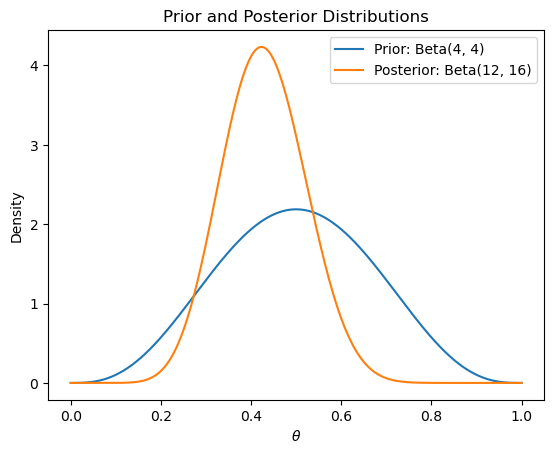

In [3]:

# Plotting the prior and posterior distributions
theta = np.linspace(0, 1, 1000)
prior = scipy.stats.beta.pdf(theta, alpha0, beta0)
posterior = scipy.stats.beta.pdf(theta, posterior_alpha, posterior_beta)

plt.plot(theta, prior, label=f'Prior: Beta({alpha0}, {beta0})')
plt.plot(theta, posterior, label=f'Posterior: Beta({posterior_alpha}, {posterior_beta})')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions')
plt.legend()
plt.show()


In [4]:
# Beta Distribution
def beta_distribution(x, a, b):
    return (math.gamma(a + b) / (math.gamma(a) * math.gamma(b))) * (x ** (a - 1)) * ((1 - x) ** (b - 1))

# Pr(D|M1)/Pr(D|M0)
def bayes_factor(theta, nx, n, alpha0, beta0):
    return (beta_distribution(theta, nx + alpha0, n - nx + beta0)) / (beta_distribution(theta, alpha0, beta0))

RB_theta_0 = bayes_factor(theta0, nx, n, alpha0, beta0)
print("Bayes Factor RB(1/2 | x):", RB_theta_0)
print("")

############

def probability_rb_less_than_given(theta, nx, n, alpha0, beta0, threshold):
    count = 0
    samples = 1000
    for _ in range(samples):
        random_theta = np.random.beta(nx + alpha0, n - nx + beta0) # random theta from posterior beta distribution
        if bayes_factor(random_theta, nx, n, alpha0, beta0) <= threshold:
            count += 1
    return count / samples

# Calculate the 0.95-credible region
credible_region = scipy.stats.beta.interval(0.95, posterior_alpha, posterior_beta)
credible_region_length = credible_region[1] - credible_region[0]
print(f"0.95-Credible Region of theta: {credible_region}")
print(f"Length of the credible region: {credible_region_length}")
print("Probability RB(theta | x) <= RB(0.5 | x) given sum(x) = 8 :", probability_rb_less_than_given(theta, nx, n, alpha0, beta0, RB_theta_0))
print("")

############

#A# 和θ = 1/2感觉没有关系？？？，这个公式并没有用到theta0
#A# 就是说在posterior的distribution里面，RB(theta | x)<1 的概率
def bias_against_H0(theta, nx, n, alpha0, beta0):
    count = 0
    samples = 1000
    for _ in range(samples):
        random_theta = np.random.beta(nx + alpha0, n - nx + beta0)
        if bayes_factor(random_theta, nx, n, alpha0, beta0) <= 1:
            count += 1
    return count / samples
n = 0
nx = 0
bias = bias_against_H0(theta0, nx, n, alpha0, beta0)

print("Bias against H0: θ = 1/2:", bias)

# Given data
bias = bias_against_H0(theta0, nx, n, alpha0, beta0)

print("Bias against H0: θ = 1/2:", bias)
print("")

############


# Function to compute the relative belief ratio
def relative_belief_ratio(theta, alpha_prior, beta_prior, alpha_post, beta_post):
    prior_density = scipy.stats.beta.pdf(theta, alpha_prior, beta_prior)
    posterior_density = scipy.stats.beta.pdf(theta, alpha_post, beta_post)
    with np.errstate(divide='ignore', invalid='ignore'):
        rb_ratio = np.where(prior_density > 0, posterior_density / prior_density, np.inf)
    return rb_ratio

# Compute the probability that RB(theta|0.5) <= 1 under the prior theta = 0.5
theta_samples = np.linspace(0, 1, 1000)
rb_values = relative_belief_ratio(theta_samples, alpha0, beta0, posterior_alpha, posterior_beta)
probability = np.mean(rb_values <= 1)

print(f"Relative belief ratio at theta = 0.5: {RB_theta_0}")
print(f"Probability that RB(theta|0.5) <= 1 under the prior: {1-probability}")

Bayes Factor RB(1/2 | x): 1.421017783028739

0.95-Credible Region of theta: (0.2547988066317378, 0.6120160697403181)
Length of the credible region: 0.35721726310858026
Probability RB(theta | x) <= RB(0.5 | x) given sum(x) = 8 : 0.304

Bias against H0: θ = 1/2: 1.0
Bias against H0: θ = 1/2: 1.0

Relative belief ratio at theta = 0.5: 1.421017783028739
Probability that RB(theta|0.5) <= 1 under the prior: 0.266


## Bias Against - Hypothesis

In [5]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
theta0 = 0.5
x = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])

In [6]:
np.mean(x) # which is the same as the avg in the paper(= 0.4)

0.4

In [7]:
def beta_logp_pm(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))
def beta_logp_np(a, b, x):
    return (a - 1) * np.log(x) + (b - 1) * np.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))
def bernoulli_logp_np(p, x):
    return x * np.log(p) + (1 - x) * np.log(1 - p)
def bernoulli_logp_pm(p, x):
    return x * pm.math.log(p) + (1 - x) * pm.math.log(1 - p)

In [8]:
# use x_
with pm.Model() as m:
    
    # Traditional analysis
        #theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
        #y = pm.Bernoulli("y", p=theta, observed=x)
    
    # "empty model" MCMC sample over prior and prior predictive data
    theta_ = pm.Beta("theta_", alpha=alpha0, beta=beta0)

    # Bias against
    x_ = pm.Bernoulli("x_", p=theta0, shape=n)
    
    # Prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp_pm(alpha0, beta0, theta0))

    # Posterior calculations

    posterior_alpha = pm.math.sum(x_)+alpha0
    posterior_beta = n - pm.math.sum(x_)+beta0
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd", 
                                          pm.logp(pm.Beta.dist(posterior_alpha, posterior_beta),theta0))

    # log RB ratio
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd - prior_prior_pd)
    
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", bernoulli_logp_pm(theta0,x_).sum())
    
    # Sample from the model
    idata = pm.sample(1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta_]
>BinaryGibbsMetropolis: [x_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


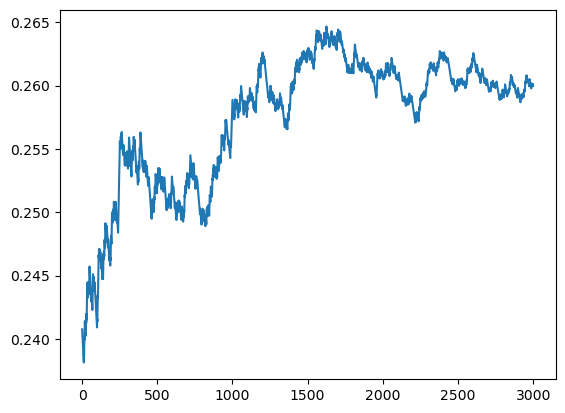

In [9]:
bias_against = idata.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_against_mci[burn:]); 

## Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


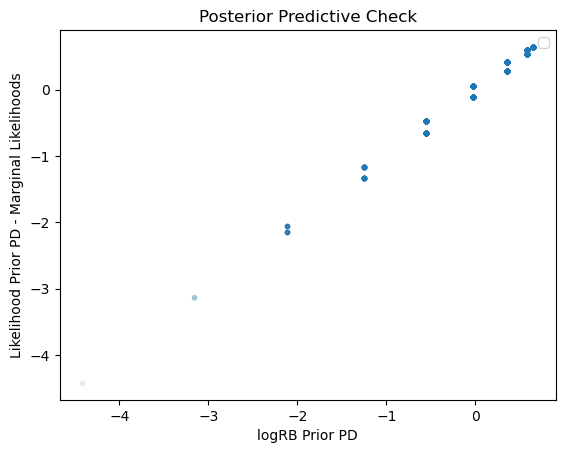

In [10]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape) + [use])

# Getting likelihoods for each x_ under each theta_
for i, m in enumerate(idata.posterior['theta_'].values.ravel()[:use]):
    marginal_likelihoods[:, :, :, i] = bernoulli_logp_np(m, idata.posterior['x_'].values)  

# Summing the log likelihoods and then taking the average over the parameter samples
marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel())  

plt.plot(idata.posterior['logRB_prior_pd'].values.ravel(), 
         idata.posterior['likelihood_prior_pd'].values.ravel() - marginal_likelihoods_, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check')
plt.legend()
plt.show()

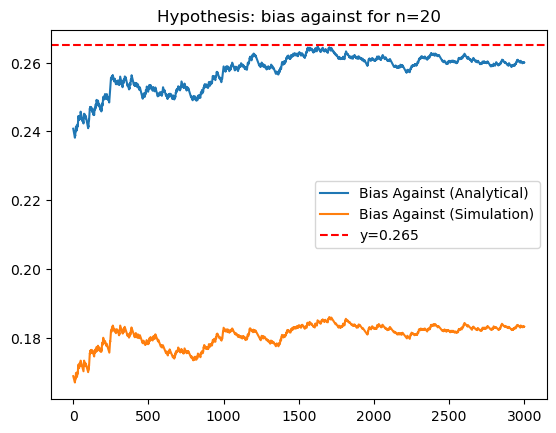

In [11]:
# Analytics
bias_against = idata.posterior['logRB_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')

# Simulation
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')

plt.title("Hypothesis: bias against for n={}".format(n))
plt.axhline(y=0.265, color='r', linestyle='--', label='y=0.265')
plt.legend()

## Bias in Flavor for Beta Model

In [12]:
alpha0 = 4
beta0 = 4
n = 20  # number of observations
delta = 0.05
theta0 = 0.5
#data1 = np.random.binomial(1, theta0+delta, n)
#data2 = np.random.binomial(1,theta0-delta, n)


In [13]:
with pm.Model() as minflavor:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)
   
    #prior_prior_pd1 = pm.Deterministic("prior_prior_pd1", beta_logp_pm(alpha0, beta0, theta0+delta))
    #prior_prior_pd2 = pm.Deterministic("prior_prior_pd2", beta_logp_pm(alpha0, beta0, theta0-delta))
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp_pm(alpha0, beta0, theta0))
    
    # Posterior calculations
    posterior_alpha1 = pm.math.sum(xu_)+alpha0
    posterior_beta1 = n - pm.math.sum(xu_)+beta0
    posterior_prior_pd1 = pm.Deterministic("posterior_prior_pd1", 
                                           pm.logp(pm.Beta.dist(posterior_alpha1, posterior_beta1),theta0))

    posterior_alpha2 = pm.math.sum(xl_)+alpha0
    posterior_beta2 = n - pm.math.sum(xl_)+beta0
    posterior_prior_pd2 = pm.Deterministic("posterior_prior_pd2", 
                                           pm.logp(pm.Beta.dist(posterior_alpha2, posterior_beta2),theta0))

    # log RB ratio
    logRB_prior_pd1 = pm.Deterministic("logRB_prior_pd1", posterior_prior_pd1 - prior_prior_pd)
    logRB_prior_pd2 = pm.Deterministic("logRB_prior_pd2", posterior_prior_pd2 - prior_prior_pd)

    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", bernoulli_logp_pm(theta0,xu_).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", bernoulli_logp_pm(theta0,xl_).sum())
    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta).sum())
    #likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta).sum())

    # Sample from the model
    inflavor = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [xl_, xu_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


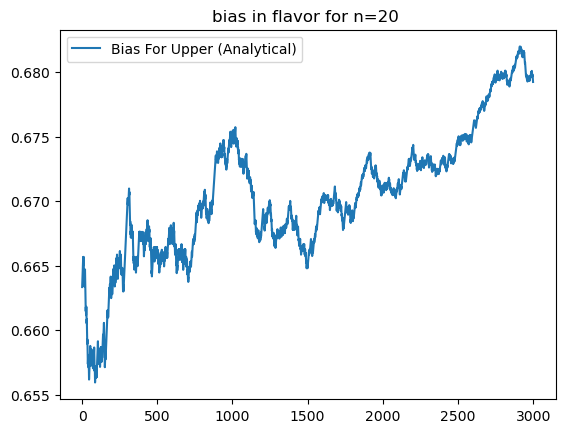

In [14]:
bias_inflavor = inflavor.posterior['logRB_prior_pd1'].values.ravel()>=0
t = bias_inflavor.shape[0]
bias_inflavor_mci = bias_inflavor.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_inflavor_mci[burn:], label='Bias For Upper (Analytical)')
plt.title("bias in flavor for n={} ".format(n))
plt.legend()

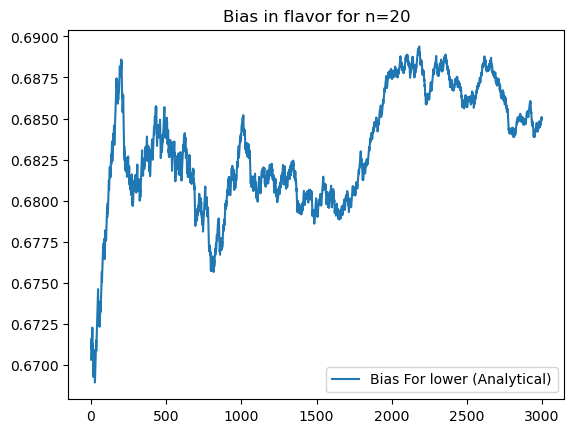

In [15]:
bias_inflavor = inflavor.posterior['logRB_prior_pd2'].values.ravel()>=0
t = bias_inflavor.shape[0]
bias_inflavor_mci = bias_inflavor.cumsum()/np.arange(1,t+1)
burn = 1000
plt.plot(bias_inflavor_mci[burn:], label='Bias For lower (Analytical)')
plt.title("Bias in flavor for n={}".format(n))
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


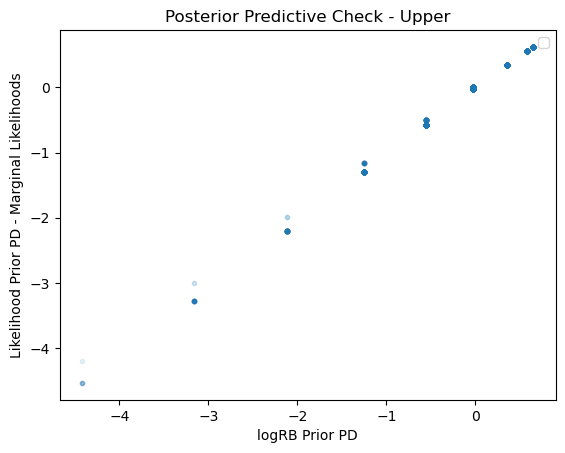

In [16]:
use = 1000
marginal_likelihoods1 = np.zeros(list(inflavor.posterior['xu_'].values.shape) + [use])
for i, m in enumerate(inflavor.posterior['theta'].values.ravel()[:use]):
    marginal_likelihoods1[:, :, :, i] = bernoulli_logp_np(m, inflavor.posterior['xu_'].values)  # Getting likelihoods for each x_ under each theta_
    #marginal_likelihoods1[:, :, :, i] = beta_logp_np(inflavor.posterior['xu_'].values + alpha0, n - inflavor.posterior['xu_'].values + beta0, m)
marginal_likelihoods_1 = np.log(np.exp(marginal_likelihoods1.sum(axis=2)).mean(axis=-1).ravel())  # Summing the log likelihoods and then taking the average over the parameter samples

plt.plot(inflavor.posterior['logRB_prior_pd1'].values.ravel(), 
         inflavor.posterior['likelihood_prior_pd1'].values.ravel() - marginal_likelihoods_1, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check - Upper')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


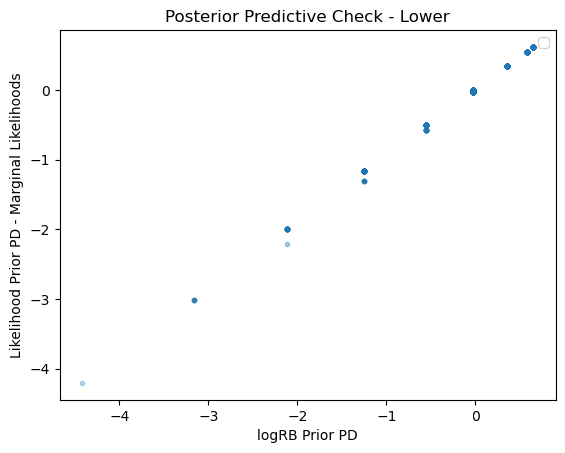

In [17]:
use = 1000
marginal_likelihoods2 = np.zeros(list(inflavor.posterior['xl_'].values.shape) + [use])
for i, m in enumerate(inflavor.posterior['theta'].values.ravel()[:use]):
    #marginal_likelihoods1[:, :, :, i] = beta_logp_np(inflavor.posterior['xl_'].values + alpha0, n - inflavor.posterior['xl_'].values + beta0, m)
    marginal_likelihoods2[:, :, :, i] = bernoulli_logp_np(m, inflavor.posterior['xl_'].values)  # Getting likelihoods for each x_ under each theta_

marginal_likelihoods_2 = np.log(np.exp(marginal_likelihoods2.sum(axis=2)).mean(axis=-1).ravel())  # Summing the log likelihoods and then taking the average over the parameter samples

plt.plot(inflavor.posterior['logRB_prior_pd2'].values.ravel(), 
         inflavor.posterior['likelihood_prior_pd2'].values.ravel() - marginal_likelihoods_2, '.', alpha=0.1)
plt.xlabel('logRB Prior PD')
plt.ylabel('Likelihood Prior PD - Marginal Likelihoods')
plt.title('Posterior Predictive Check - Lower')
plt.legend()
plt.show()

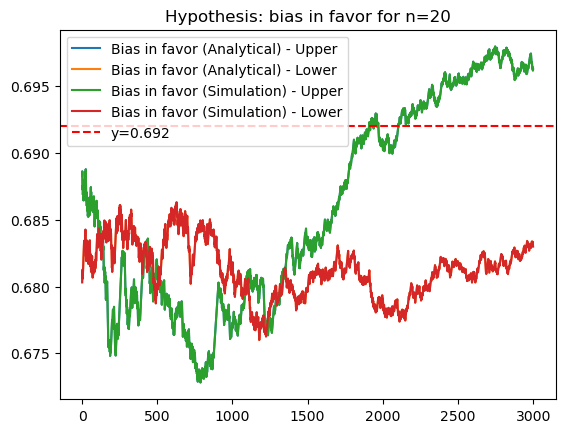

In [18]:
# Analytics
## 前面是theta0，后面theta_
burn = 1000
bias_inflavor1 = inflavor.posterior['logRB_prior_pd1'].values.ravel() >= 0
t1 = bias_inflavor1.shape[0]
bias_inflavor_mci1 = bias_inflavor1.cumsum()/np.arange(1,t1+1)
plt.plot(bias_inflavor_mci1[burn:], label='Bias in favor (Analytical) - Upper')

bias_inflavor2 = inflavor.posterior['logRB_prior_pd2'].values.ravel() >= 0
t2 = bias_inflavor2.shape[0]
bias_inflavor_mci2 = bias_inflavor2.cumsum()/np.arange(1,t2+1)
plt.plot(bias_inflavor_mci2[burn:], label='Bias in favor (Analytical) - Lower')


# Simulation
bias_inflavor_ml1 = (inflavor.posterior['likelihood_prior_pd1'].values.ravel()-marginal_likelihoods_1) >= 0
bias_inflavor_ml_mci1 = bias_inflavor_ml1.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci1[burn:], label='Bias in favor (Simulation) - Upper')

bias_inflavor_ml2 = (inflavor.posterior['likelihood_prior_pd2'].values.ravel()-marginal_likelihoods_2) >= 0
bias_inflavor_ml_mci2 = bias_inflavor_ml2.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci2[burn:], label='Bias in favor (Simulation) - Lower')

plt.title("Hypothesis: bias in favor for n={}".format(n))
plt.axhline(y=0.692, color='r', linestyle='--', label='y=0.692')
plt.legend()

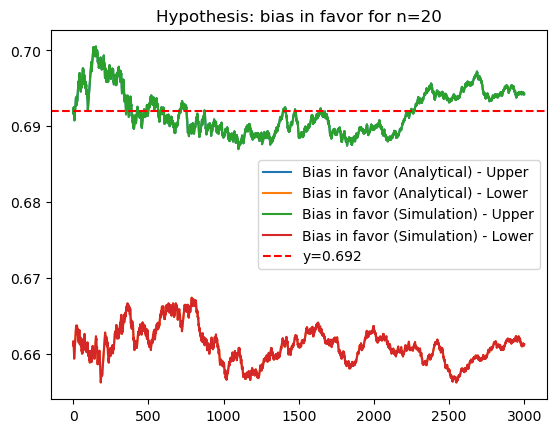

In [25]:
# Analytics
## 前面是theta0，后面theta_
burn = 1000
bias_inflavor1 = inflavor.posterior['logRB_prior_pd1'].values.ravel() >= 0
t1 = bias_inflavor1.shape[0]
bias_inflavor_mci1 = bias_inflavor1.cumsum()/np.arange(1,t1+1)
plt.plot(bias_inflavor_mci1[burn:], label='Bias in favor (Analytical) - Upper')

bias_inflavor2 = inflavor.posterior['logRB_prior_pd2'].values.ravel() >= 0
t2 = bias_inflavor2.shape[0]
bias_inflavor_mci2 = bias_inflavor2.cumsum()/np.arange(1,t2+1)
plt.plot(bias_inflavor_mci2[burn:], label='Bias in favor (Analytical) - Lower')


# Simulation
bias_inflavor_ml1 = (inflavor.posterior['likelihood_prior_pd1'].values.ravel()-marginal_likelihoods_1) >= 0
bias_inflavor_ml_mci1 = bias_inflavor_ml1.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci1[burn:], label='Bias in favor (Simulation) - Upper')

bias_inflavor_ml2 = (inflavor.posterior['likelihood_prior_pd2'].values.ravel()-marginal_likelihoods_2) >= 0
bias_inflavor_ml_mci2 = bias_inflavor_ml2.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci2[burn:], label='Bias in favor (Simulation) - Lower')

plt.title("Hypothesis: bias in favor for n={}".format(n))
plt.axhline(y=0.692, color='r', linestyle='--', label='y=0.692')
plt.legend()

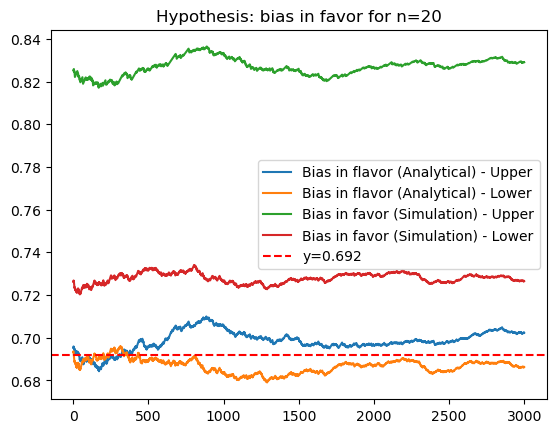

In [32]:
# Analytics
#前面是theta0，后面theta_
burn = 1000
bias_inflavor1 = inflavor.posterior['logRB_prior_pd1'].values.ravel() >= 0
t1 = bias_inflavor1.shape[0]
bias_inflavor_mci1 = bias_inflavor1.cumsum()/np.arange(1,t1+1)
plt.plot(bias_inflavor_mci1[burn:], label='Bias in favor (Analytical) - Upper')

bias_inflavor2 = inflavor.posterior['logRB_prior_pd2'].values.ravel() >= 0
t2 = bias_inflavor2.shape[0]
bias_inflavor_mci2 = bias_inflavor2.cumsum()/np.arange(1,t2+1)
plt.plot(bias_inflavor_mci2[burn:], label='Bias in favor (Analytical) - Lower')


# Simulation
bias_inflavor_ml1 = (inflavor.posterior['likelihood_prior_pd1'].values.ravel()-marginal_likelihoods_1) >= 0
bias_inflavor_ml_mci1 = bias_inflavor_ml1.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci1[burn:], label='Bias in favor (Simulation) - Upper')
bias_inflavor_ml2 = (inflavor.posterior['likelihood_prior_pd2'].values.ravel()-marginal_likelihoods_2) >= 0
bias_inflavor_ml_mci2 = bias_inflavor_ml2.cumsum()/np.arange(1,t+1)
plt.plot(bias_inflavor_ml_mci2[burn:], label='Bias in favor (Simulation) - Lower')

plt.title("Hypothesis: bias in favor for n={}".format(n))
plt.axhline(y=0.692, color='r', linestyle='--', label='y=0.692')
plt.legend()

In [ ]:
with pm.Model() as minflavor:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)
   
    #prior_prior_pd1 = pm.Deterministic("prior_prior_pd1", beta_logp_pm(alpha0, beta0, theta0+delta))
    #prior_prior_pd2 = pm.Deterministic("prior_prior_pd2", beta_logp_pm(alpha0, beta0, theta0-delta))
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp_pm(alpha0, beta0, theta0))
    
    # Posterior calculations
    posterior_alpha1 = pm.math.sum(xu_)+alpha0
    posterior_beta1 = n - pm.math.sum(xu_)+beta0
    posterior_prior_pd1 = pm.Deterministic("posterior_prior_pd1", 
                                           pm.logp(pm.Beta.dist(posterior_alpha1, posterior_beta1),theta0))

    posterior_alpha2 = pm.math.sum(xl_)+alpha0
    posterior_beta2 = n - pm.math.sum(xl_)+beta0
    posterior_prior_pd2 = pm.Deterministic("posterior_prior_pd2", 
                                           pm.logp(pm.Beta.dist(posterior_alpha2, posterior_beta2),theta0))

    # log RB ratio
    logRB_prior_pd1 = pm.Deterministic("logRB_prior_pd1", posterior_prior_pd1 - prior_prior_pd)
    logRB_prior_pd2 = pm.Deterministic("logRB_prior_pd2", posterior_prior_pd2 - prior_prior_pd)

    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", bernoulli_logp_pm(theta0,xu_).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", bernoulli_logp_pm(theta0,xl_).sum())
    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta).sum())
    #likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta).sum())

    # Sample from the model
    inflavor = pm.sample(1000, return_inferencedata=True)

# Estimation

### Bias Against

In [ ]:
# use x_
# use theta_

with pm.Model() as m:
    
    # Traditional analysis
        #theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
        #y = pm.Bernoulli("y", p=theta, observed=x)
    
    # "empty model" MCMC sample over prior and prior predictive data
    theta_ = pm.Beta("theta_", alpha=alpha0, beta=beta0)

    # Bias against
    x_ = pm.Bernoulli("x_", p=theta_, shape=n)
    
    # Prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", beta_logp_pm(alpha0, beta0, theta_))
    
    # Posterior calculations

    posterior_alpha = pm.math.sum(x_)+alpha0
    posterior_beta = n - pm.math.sum(x_)+beta0
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd", 
                                          pm.logp(pm.Beta.dist(posterior_alpha, posterior_beta),theta_

    # log RB ratio
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd - prior_prior_pd)
    
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", bernoulli_logp_pm(theta_,x_).sum())
    
    # Sample from the model
    idata = pm.sample(1000, return_inferencedata=True)


### Bias in flavour

In [62]:
##

with pm.Model() as minflavor:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)
   
    prior_prior_pd1 = pm.Deterministic("prior_prior_pd1", beta_logp_pm(alpha0, beta0, theta+delta))
    prior_prior_pd2 = pm.Deterministic("prior_prior_pd2", beta_logp_pm(alpha0, beta0, theta-delta))
    
    # Posterior calculations
    posterior_alpha1 = pm.math.sum(xu_)+alpha0
    posterior_beta1 = n - pm.math.sum(xu_)+beta0
    posterior_prior_pd1 = pm.Deterministic("posterior_prior_pd1", 
                                           pm.logp(pm.Beta.dist(posterior_alpha1, posterior_beta1),theta+delta))

    posterior_alpha2 = pm.math.sum(xl_)+alpha0
    posterior_beta2 = n - pm.math.sum(xl_)+beta0
    posterior_prior_pd2 = pm.Deterministic("posterior_prior_pd2", 
                                           pm.logp(pm.Beta.dist(posterior_alpha2, posterior_beta2),theta-delta))

    # log RB ratio
    logRB_prior_pd1 = pm.Deterministic("logRB_prior_pd1", posterior_prior_pd1 - prior_prior_pd1)
    logRB_prior_pd2 = pm.Deterministic("logRB_prior_pd2", posterior_prior_pd2 - prior_prior_pd2)

    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", bernoulli_logp_pm(theta,xu_).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", bernoulli_logp_pm(theta,xl_).sum())
    
    # Sample from the model
    inflavor = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [xl_, xu_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.


In [ ]:
mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
delta = 0.05
mu_lower = mu_0 - delta
mu_upper = mu_0 + delta
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    xl_ = pm.Normal('xl_', mu=mu_lower, sigma=1, shape=n)
    xu_ = pm.Normal('xu_', mu=mu_upper, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)

    posterior_meanl = (mu_prior_mean/mu_prior_sigma**2 + xl_.sum()/1)*posterior_var
    posterior_meanu = (mu_prior_mean/mu_prior_sigma**2 + xu_.sum()/1)*posterior_var

    posterior_prior_pdl = pm.Deterministic("posterior_prior_pdl",
                                          normal_logp(mu_0, posterior_meanl, posterior_var**0.5))
    posterior_prior_pdu = pm.Deterministic("posterior_prior_pdu",
                                          normal_logp(mu_0, posterior_meanu, posterior_var**0.5))

    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_prior_pdl-prior_prior_pd) # pm.math.exp()
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_prior_pdu-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pdlower = pm.Deterministic("likelihood_prior_pdlower", normal_logp(xl_,mu_0-delta,1).sum())
    likelihood_prior_pdupper = pm.Deterministic("likelihood_prior_pdupper", normal_logp(xu_,mu_0+delta,1).sum())

with m:
    idata = pm.sample(draws=1000)